# Efficient Retrieval of Music Recordings Using Graph-Based Index Structures

This notebook accompanies the following paper:

<ul>    
<li><span style="color:black">
Frank Zalkow, Julian Brandner, and Meinard Müller. <strong>Efficient retrieval of music recordings using graph-based index structures.</strong> <em>Signals</em>, 2(2):336–352, 2021. doi: 10.3390/signals2020021.
    <a class="btn btn-default btn-xs" href="https://www.mdpi.com/2624-6120/2/2/21">Paper</a>
    <a class="btn btn-default btn-xs" href="https://www.audiolabs-erlangen.de/resources/MIR/2020_signals-indexing/reference_paper.bib">Bibtex</a>
    <a class="btn btn-default btn-xs" href="https://www.audiolabs-erlangen.de/resources/MIR/2020_signals-indexing">Website</a>
</ul>
    
The paper compares indexing strategies based on $K$-d trees and HNSW graphs in a cross-modal music retrieval application. See more details in the paper. The notebook shows how to load the features for a provided example dataset, generate shingles, reduce the shingle dimensionality using PCA, construct index structures ($K$-d trees and HNSW graphs), and search for the nearest shingles to a given query in the database.
    
We start by importing some Python packages.

In [1]:
import os
import timeit

import numpy as np
import scipy
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KDTree
import IPython.display as ipd
import hnswlib
from matplotlib import pyplot as plt

from common import compute_features, generate_shingles

## Parameters

We now set various parameters used throughout this notebook.
First, we decide whether we use dimensionality reduction (binary variable `dimensionality_reduction`).
Second, we fix the used dimensionality $K$ (`K`, changed to 240 later if no dimensionality reduction is applied).
Third, we set the number $\nu$ of neighbors to search for (`nu`).

Then, we have three more parameters for the HNSW graph, i.e., number $\nu'$ of neighbor candidates during the search (`nu_prime`), the minimum number $M$ of edges for each node in the graph (`M`), and the number $M'$ of edge candidates during the construction of the graph (`M_prime`).
For details about the meaning of these parameters, we refer to our paper.

In [2]:
dimensionality_reduction = True
K = 30
nu = 10

nu_prime = 100
M = 5
M_prime = 100

## Load Dataset

We next load the metadata and the CENS features for our dataset.
Then, we generate shingles (as vectors of 240 dimensions) from the feature sequences and an index that specifies the original document for each shingle.

In [17]:
metadata = pd.read_csv(os.path.join('data', 'metadata.csv'), sep=';')

shingles = []
index = []
 
for _, (cur_idx, cur_composer, cur_work, cur_version, cur_fn) in metadata.iterrows():
    cur_fn_npz = os.path.join('data', 'features_cens', cur_fn)
    cur_X = np.load(cur_fn_npz)['f_chroma']
    cur_shingles = generate_shingles(cur_X) # apply model embedding
    
    shingles.append(cur_shingles)
    index.append(np.repeat(cur_idx, cur_shingles.shape[0]))
    
shingles = np.concatenate(shingles, axis=0)
index = np.concatenate(index)

db_size = shingles.shape[0]

In [20]:
index.shape

(52332,)

To give an overview of the dataset, we create a table with the dataset's musical works, showing the number of versions for each work.

In [4]:
works_with_count = metadata[['ComposerID', 'WorkID']].value_counts(sort=False).to_frame()
works_with_count = pd.DataFrame(works_with_count.to_records())
works_with_count.columns = ['ComposerID', 'WorkID', '# Versions']

ipd.display(ipd.HTML(works_with_count.to_html(index=False)))

ComposerID,WorkID,# Versions
Beethoven,Op055-01,4
Beethoven,Op055-02,4
Beethoven,Op055-03,4
Beethoven,Op055-04,4
Chopin,Op007No1,53
Chopin,Op024No1,61
Chopin,Op033No2,67
Chopin,Op033No3,50
Chopin,Op068No4,62
Vivaldi,RV269-01,7


To give a concrete idea about the dataset content, we now select a random shingle from the dataset, show its corresponding metadata, and visualize the shingle.

,Index,ComposerID,WorkID,VersionID,Filename
72,72,Chopin,Op024No1,Barbosa-1983_pid9174-14,Chopin_Op024No1_Barbosa-1983_pid9174-14.npz


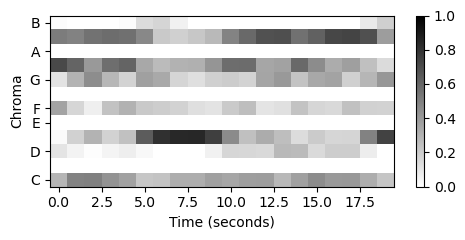

In [5]:
example_idx = np.random.randint(0, shingles.shape[0])
example_item = shingles[example_idx, :]

ipd.display(ipd.HTML(metadata[metadata['Index'] == index[example_idx]].to_html()))

plt.figure(figsize=(5, 2.5))
plt.imshow(example_item.reshape(12, 20), aspect='auto', origin='lower', cmap='gray_r', vmin=0, vmax=1)
plt.yticks([0, 2, 4, 5, 7, 9, 11], 'CDEFGAB')
plt.ylabel('Chroma')
plt.xlabel('Time (seconds)')
plt.colorbar()
plt.tight_layout()

## Dimensionality Reduction

If required, we perform dimensionality reduction to the shingle using PCA.

In [6]:
if dimensionality_reduction:
    pca = PCA(n_components=K)
    pca.fit(shingles)
    items = pca.transform(shingles)
else:
    items = shingles
    K = shingles.shape[1]

## Query

In this notebook, we use a query from the database to demonstrate the usage of the index structures.
You may also use another query by computing the features for an audio file.
To do this, we provide the functions `common.compute_features` and `common.generate_shingles`.

In [7]:
query_idx = np.random.randint(0, items.shape[0])
query_item = items[query_idx, :]

print('Query')
ipd.display(ipd.HTML(metadata[metadata['Index'] == index[query_idx]].to_html()))

# to use another query, you can compute a query item from an audio file
# import librosa
# fn_audio = '...'  # please provide the path to an audio file
# X_cens = compute_features(fn_audio)
# query_shingle = generate_shingles(X_cens)[0, :]  # using the first shingle from the file
# query_item = pca.transform(query_shingle.reshape(1, -1))[0] if dimensionality_reduction else query_shingle

Query


,Index,ComposerID,WorkID,VersionID,Filename
271,271,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,Chopin_Op068No4_Gornostaeva-1994_pid9116-11.npz


## Exhaustive Nearest Neighbor Search

Now, we search for the $\nu$ nearest shingles in our dataset using an exhaustive search.
Here, we compute a matrix of pairwise distances between the query and all database items and select the items corresponding to the $\nu$ smallest distances.

In [8]:
def exhaustive_search(database, queries, n_neighbors):
    C = scipy.spatial.distance.cdist(database, queries, metric='euclidean')
    neighbor_idx = np.argsort(C, axis=0)[:n_neighbors, :]
    neighbor_dist = C[np.unravel_index(neighbor_idx, C.shape)]
    return neighbor_idx, neighbor_dist
    
neighbor_idx, neighbor_dist = exhaustive_search(items, query_item.reshape(1, -1), nu)
neighbor_dist = np.square(neighbor_dist)  # show squared Euclidean distance

We next show the results of the search using the function `show_result_table`.

In [9]:
def show_result_table(neighbor_idx, neighbor_dist, index=index, metadata=metadata):
    neighbor_idx = neighbor_idx.ravel()
    neighbor_dist = neighbor_dist.ravel()
    
    table = []
    for i, (cur_item_idx, cur_dist) in enumerate(zip(neighbor_idx, neighbor_dist)):
        cur_version_idx = index[cur_item_idx]
        cur_meta_row = metadata[metadata['Index'] == cur_version_idx].iloc[0]
        
        table.append([f'{i + 1:02d}', cur_meta_row['ComposerID'], cur_meta_row['WorkID'],
                      cur_meta_row['VersionID'], cur_item_idx, cur_dist])
    
    cols = ['Match', 'ComposerID', 'WorkID', 'VersionID', 'ShingleIdx', 'Distance']
    ipd.display(ipd.HTML(pd.DataFrame(table, columns=cols).to_html(index=False)))
    
print('Results of exhaustive search')
show_result_table(neighbor_idx, neighbor_dist)

Results of exhaustive search


Match,ComposerID,WorkID,VersionID,ShingleIdx,Distance
01,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,43272,0.000000
02,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,43271,0.431652
03,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,43273,0.471303
04,Chopin,Op068No4,Fou-1955_pid9085-22,42683,1.433297
05,Chopin,Op068No4,Guller-1956_pid9176-09,43363,1.561083
06,Chopin,Op068No4,Luisada-1991_pid9055b-20,44822,1.561119
07,Chopin,Op068No4,Moravec-1989_pid5667271-06,45769,1.561215
08,Chopin,Op068No4,Milkina-1970_pid9099b-26,45505,1.620660
09,Chopin,Op068No4,Moravec-1989_pid5667271-06,45768,1.722797
10,Chopin,Op068No4,Blet-2003_pid9103-23,41016,1.725613


## Nearest Neighbor Search with $K$-d tree

Next, we construct a $K$-d tree for our dataset and search for the $\nu$ nearest shingles using this tree.
We then show the results as a table.

In [10]:
neighbors = NearestNeighbors(n_neighbors=nu, metric='euclidean')
neighbors.fit(items)

assert isinstance(neighbors._tree, KDTree)

neighbor_dist, neighbor_idx = neighbors.kneighbors(query_item.reshape(1, -1), nu)
neighbor_dist = np.square(neighbor_dist)  # show squared Euclidean distance

print('Results of search with K-d tree')
show_result_table(neighbor_idx, neighbor_dist)

AssertionError: 

## Nearest Neighbor Search with HNSW Graph

Finally, we construct an HNSW graph for our dataset and search for the $\nu$ nearest shingles using this graph.
We then show the results as a table.

In [12]:
graph = hnswlib.Index(space='l2', dim=K)
graph.init_index(max_elements=items.shape[0], ef_construction=M_prime, M=M)
graph.set_ef(nu_prime)
graph.add_items(items, np.arange(items.shape[0]))

neighbor_idx, neighbor_dist = graph.knn_query(query_item.reshape(1, -1), k=nu)

print('Results of search with HNSW graph')
show_result_table(neighbor_idx, neighbor_dist)

Results of search with HNSW graph


Match,ComposerID,WorkID,VersionID,ShingleIdx,Distance
01,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,43272,0.000000
02,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,43271,0.431652
03,Chopin,Op068No4,Gornostaeva-1994_pid9116-11,43273,0.471303
04,Chopin,Op068No4,Fou-1955_pid9085-22,42683,1.433297
05,Chopin,Op068No4,Guller-1956_pid9176-09,43363,1.561083
06,Chopin,Op068No4,Luisada-1991_pid9055b-20,44822,1.561119
07,Chopin,Op068No4,Moravec-1989_pid5667271-06,45769,1.561215
08,Chopin,Op068No4,Milkina-1970_pid9099b-26,45505,1.620660
09,Chopin,Op068No4,Moravec-1989_pid5667271-06,45768,1.722797
10,Chopin,Op068No4,Blet-2003_pid9103-23,41016,1.725613


## Retrieval Runtime

The aim of using index structures in our music application is to increase the efficiency of the retrieval runtime.
In the next code cell, we compare the runtimes of the different search strategies.
First, we define functions with a consistent interface for the exhaustive search, the $K$-d tree search, and the HNSW-based search.
Then we measure the runtimes of these functions using the Python module `timeit`.

In [16]:
def kd(neighbors, queries, n_neighbors):
    neighbor_dist, neighbor_idx = neighbors.kneighbors(queries, nu)
    return neighbor_idx, neighbor_dist

def hnsw(graph, queries, n_neighbors):
    neighbor_idx, neighbor_dist = graph.knn_query(queries, k=nu)
    return neighbor_idx, neighbor_dist
    
# measure runtimes
times_fullsearch = timeit.repeat('exhaustive_search(items, query_item.reshape(1, -1), nu)',
                                 globals=globals(), number=1, repeat=100)
times_kd = timeit.repeat('kd(neighbors, query_item.reshape(1, -1), nu)',
                         globals=globals(), number=1, repeat=100)
times_hnsw = timeit.repeat('hnsw(graph, query_item.reshape(1, -1), nu)',
                           globals=globals(), number=1, repeat=100)

# convert from second to milliseconds
times_fullsearch = np.array(times_fullsearch) * 1000
times_kd = np.array(times_kd) * 1000
times_hnsw = np.array(times_hnsw) * 1000

# report results
print(f'Full Search: {np.mean(times_fullsearch):.3f} ms +/- {np.std(times_fullsearch):.1f} ms')
print(f'KD:          {np.mean(times_kd):.3f} ms +/- {np.std(times_kd):.1f} ms')
print(f'HNSW:        {np.mean(times_hnsw):.3f} ms +/- {np.std(times_hnsw):.1f} ms')

Full Search: 5.551 ms +/- 0.4 ms
KD:          2.149 ms +/- 0.2 ms
HNSW:        0.011 ms +/- 0.0 ms


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
    <strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow/">Frank Zalkow</a>.
</div>